<a href="https://colab.research.google.com/github/JoeyBarlia/Drilling-Failure-Analysis/blob/main/Data_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Descriptive and Inferential Analysis

#### The original dataset used for this EDA is from the following publication.

 S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

This synthetic dataset is modeled after an existing milling machine and consists of 10,000 data points stored as rows with 14 features in columns.

1. UID: unique identifier ranging from 1 to 10000

2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number

3. type: just the product type L, M or H from column 2

4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.

8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('ai4i2020.csv')

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [ ]:
df[df.duplicated()]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


No nulls and no duplicates. Great. Moving on.

In [ ]:
#Dropping UDI and Product ID columns since they dont carry valuable information
df = df.drop(["UDI", "Product ID"], axis=1)

In [ ]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


**How many machine failures are in the dataset?**


In [ ]:
df['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,339


Noticeable class  imbalance. Will keep this in mind for future machine learning.

**What are the most common failures?**

In [ ]:
df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].apply(pd.Series.value_counts)

,TWF,HDF,PWF,OSF,RNF
0,9954,9885,9905,9902,9981
1,46,115,95,98,19


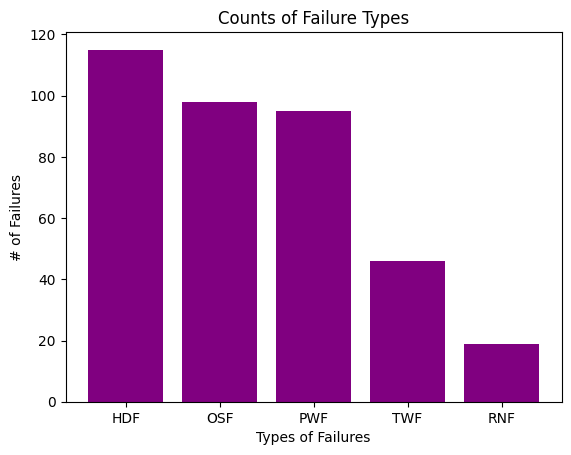

In [ ]:
values = [115, 98, 95, 46, 19]

labels = ["HDF", "OSF", "PWF", "TWF", "RNF"]

plt.bar(labels, values, color="purple")
plt.title("Counts of Failure Types")
plt.xlabel("Types of Failures")
plt.ylabel("# of Failures")
plt.xticks(rotation=0)
plt.show()

Wait a minute...those add up to 373. Machine failure count was 339. There must be instances of multiple failures happening at once.

**What is the occurence of multiple failures happening at once?**

Text(0.5, 1.0, 'Number of failure types per record')

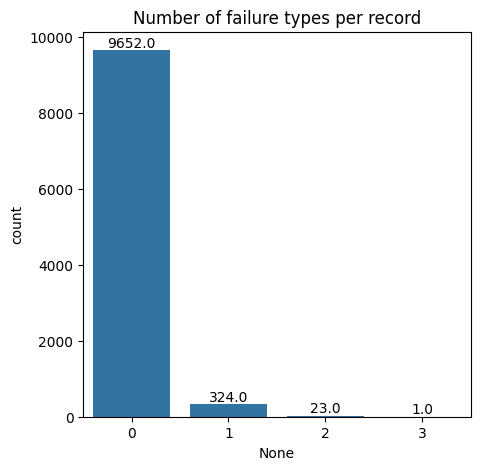

In [ ]:
df_failures = df.loc[:, ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

rows_sum = df_failures.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
ax.set_title('Number of failure types per record')

As we can see, there are 24 instances of more than one failure occuring at once. We will combine the failure types into one feature. Then drop individual failure types


In [ ]:
df.loc[df['TWF'] == 1, 'Machine failure'] = 1
df.loc[df['HDF'] == 1, 'Machine failure'] = 1
df.loc[df['PWF'] == 1, 'Machine failure'] = 1
df.loc[df['OSF'] == 1, 'Machine failure'] = 1
df.loc[df['RNF'] == 1, 'Machine failure'] = 1


df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

In [ ]:
df['Machine failure'].value_counts()

,count
Machine failure,
0,9643
1,357


**What is the percentage of machine failures by product quality?**

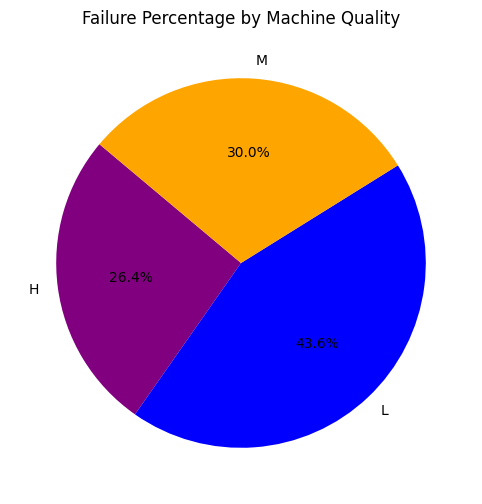

In [ ]:
failure_counts = df.groupby('Type')['Machine failure'].sum().reset_index()
failure_counts.columns = ['Machine Quality', 'Failure Count']

value_counts = df['Type'].value_counts().reset_index()
value_counts.columns = ['Machine Quality', 'Total Count']

failure_counts = failure_counts.merge(value_counts, on='Machine Quality')
failure_counts['Failure Percentage'] = (failure_counts['Failure Count'] / failure_counts['Total Count']) * 100

colors = {'L': 'blue', 'M': 'orange', 'H': 'purple'}

plt.figure(figsize=(10, 6))
plt.pie(failure_counts['Failure Percentage'], labels=failure_counts['Machine Quality'],
        autopct='%1.1f%%', startangle=140, colors=[colors[label] for label in failure_counts['Machine Quality']])
plt.title('Failure Percentage by Machine Quality')
plt.show()

Machines of high quality fail almost as much as machines of medium quality. Maybe the milling factory doesnt need to spend the extra money on high quality machines

**Which columns are most highly correlated?**

In [ ]:
# convert Type attribute into numbers, so that L = 0, M = 1, and H = 2
df['Type'].replace('L', 0, inplace=True)
df['Type'].replace('M', 1, inplace=True)
df['Type'].replace('H', 2, inplace=True)

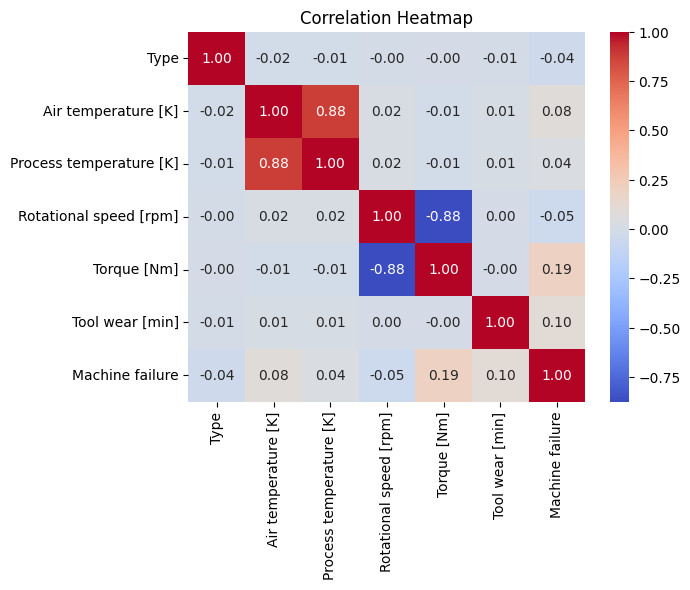

In [ ]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap');

Process temperature and air temperature are correlated which makes sense. Torque and rpm are inversely correlated as well which is a law of physics. Worth noting that the features that most strongly contribute to machine failure is torque, tool wear, and air temperature.

#Data Update

###During my research I came across a similar dataset from another publication by the same author. This dataset is still synthetic however it is twice as large and the features are more realistic. The structure is largely the same. I will move forward with this new dataset.

This dataset is part of the following publication at the TransAI 2023 conference:
R. Wallsberger, R. Knauer, S. Matzka; "Explainable Artificial Intelligence in Mechanical Engineering: A Synthetic Dataset for Comprehensive Failure Mode Analysis"
DOI: http://dx.doi.org/10.1109/TransAI60598.2023.00032
  


This is the original XAI Drilling dataset optimized for XAI purposes and it can be used to evaluate explanations of such algortihms. The dataset comprises 20,000 data points, i.e., drilling operations, stored as rows, 10 features, one binary main failure label, and 4 binary subgroup failure modes, stored in columns. The main failure rate is about 5.0 % for the whole dataset.

 The features that constitute this dataset are as follows:


  --**ID:** Every data point in the dataset is uniquely identifiable, thanks to the ID feature. This ensures traceability and easy referencing, especially when analyzing specific drilling scenarios or anomalies.

  --**Cutting speed vc (m/min)**: The cutting speed is a pivotal parameter in drilling, influencing the efficiency and quality of the drilling process. It represents the speed at which the drill bit's cutting edge moves through the material.

  --**Spindle speed n (1/min)**: This feature captures the rotational speed of the spindle or drill bit, respectively.

  --**Feed f (mm/rev)**: Feed denotes the depth the drill bit penetrates into the material with each revolution. There is a balance between speed and precision, with higher feeds leading to faster drilling but potentially compromising hole quality.

  --**Feed rate vf (mm/min)**: The feed rate is a measure of how quickly the material is fed to the drill bit. It is a determinant of the overall drilling time and influences the heat generated during the process.

  --**Power Pc (kW)**: The power consumption during drilling can be indicative of the efficiency of the process and the wear state of the drill bit.

  --**Cooling (%)**: Effective cooling is paramount in drilling, preventing overheating and reducing wear. This ordinal feature captures the cooling level applied, with four distinct states representing no cooling (0%), partial cooling (25% and 50%), and high to full cooling (75% and 100%).

  --**Material**: The type of material being drilled can significantly influence the drilling parameters and outcomes. This dataset encompasses three primary materials: C45K hot-rolled heat-treatable steel (EN 1.0503), cast iron GJL (EN GJL-250), and aluminum-silicon (AlSi) alloy (EN AC-42000), each presenting its unique challenges and considerations. The three materials are represented as “P (Steel)” for C45K, “K (Cast Iron)” for cast iron GJL and “N (Non-ferrous metal)” for AlSi alloy.

  --**Drill Bit Type**: Different materials often require specialized drill bits. This feature categorizes the type of drill bit used, ensuring compatibility with the material and optimizing the drilling process. It consists of three categories, which are based on the DIN 1836: “N” for C45K, “H” for cast iron and “W” for AlSi alloy [5].

  --**Process time t (s)**: This feature captures the full duration of each drilling operation, providing insights into efficiency and potential bottlenecks.

  --Main failure: This binary feature indicates if any significant failure on the drill bit occurred during the drilling process. A value of 1 flags a drilling process that encountered issues, which in this case is true when any of the subgroup failure modes are 1, while 0 indicates a successful drilling operation without any major failures.

Subgroup failures:

--**Build-up edge failure** (215x): Represented as a binary feature, a build-up edge failure indicates the occurrence of material accumulation on the cutting edge of the drill bit due to a combination of low cutting speeds and insufficient cooling. A value of 1 signifies the presence of this failure mode, while 0 denotes its absence.

 --**Compression chips failure** (344x): This binary feature captures the formation of compressed chips during drilling, resulting from the factors high feed rate, inadequate cooling and using an incompatible drill bit. A value of 1 indicates the occurrence of at least two of the three factors above, while 0 suggests a smooth drilling operation without compression chips.

--**Flank wear failure** (278x): A binary feature representing the wear of the drill bit's flank due to a combination of high feed rates and low cutting speeds. A value of 1 indicates significant flank wear, affecting the drilling operation's accuracy and efficiency, while 0 denotes a wear-free operation.

  --**Wrong drill bit failure** (300x): As a binary feature, it indicates the use of an inappropriate drill bit for the material being drilled. A value of 1 signifies a mismatch, leading to potential drilling issues, while 0 indicates the correct drill bit usage.

In [3]:
df = pd.read_csv('XAI_Drilling_Dataset.csv')

df.head()

,ID,Cutting speed vc [m/min],Spindle speed n [1/min],Feed f [mm/rev],Feed rate vf [mm/min],Power Pc [kW],Cooling [%],Material,Drill Bit Type,Process Time [sec],Main Failure,BEF,CCF,FWF,WDF
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0
4,5,17.43,462,0.246,114,74.85,50,K,H,33.56,0,0,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        20000 non-null  int64  
 1   Cutting speed vc [m/min]  20000 non-null  float64
 2   Spindle speed n [1/min]   20000 non-null  int64  
 3   Feed f [mm/rev]           20000 non-null  float64
 4   Feed rate vf [mm/min]     20000 non-null  int64  
 5   Power Pc [kW]             20000 non-null  float64
 6   Cooling [%]               20000 non-null  int64  
 7   Material                  20000 non-null  object 
 8   Drill Bit Type            20000 non-null  object 
 9   Process Time [sec]        20000 non-null  float64
 10  Main Failure              20000 non-null  int64  
 11  BEF                       20000 non-null  int64  
 12  CCF                       20000 non-null  int64  
 13  FWF                       20000 non-null  int64  
 14  WDF   

In [11]:
#Dropping ID column
df = df.drop(["ID"], axis=1)

How many machine failures are in this dataset?

In [12]:
df['Main Failure'].value_counts()

,count
Main Failure,
0,18999
1,1001


**What are the most common types of failures?**

In [13]:
df[['BEF', 'CCF', 'FWF', 'WDF']].apply(pd.Series.value_counts)

,BEF,CCF,FWF,WDF
0,19785,19656,19722,19700
1,215,344,278,300


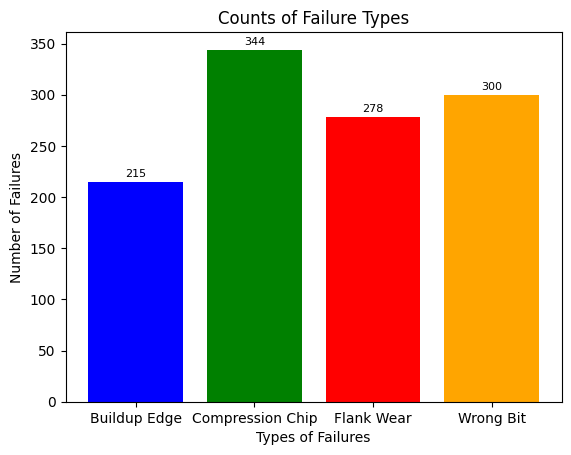

In [14]:
values = [215, 344, 278, 300]
labels = ["Buildup Edge", "Compression Chip", "Flank Wear", "Wrong Bit"]

colors = ['blue', 'green', 'red', 'orange']

plt.bar(labels, values, color=colors)

plt.title("Counts of Failure Types")
plt.xlabel("Types of Failures")
plt.ylabel("Number of Failures")
plt.xticks(rotation=0)

for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=8)

plt.show()

**What is the occurence of multiple failures at once?**

Text(0.5, 1.0, 'Number of failure types per record')

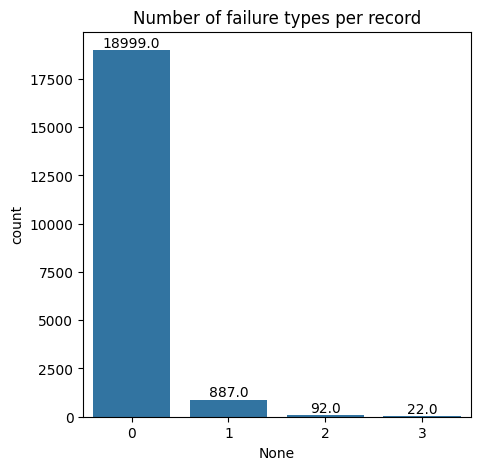

In [15]:
df_failures = df.loc[:, ['BEF', 'CCF', 'FWF', 'WDF']]

rows_sum = df_failures.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
ax.set_title('Number of failure types per record')

Number of failures adds up to 1001. Checks out.

**What is the percentage of failures represented by each material?**

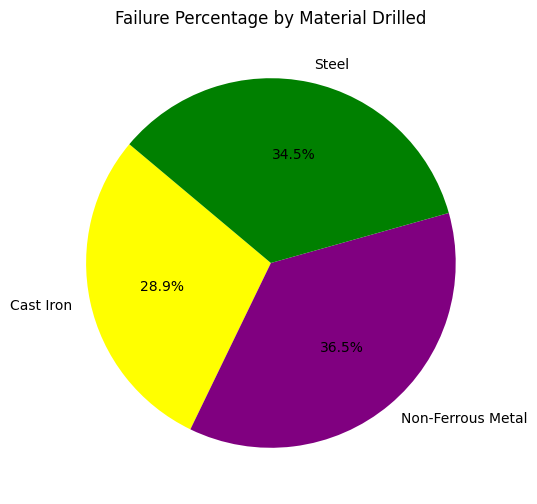

In [19]:
failure_counts = df.groupby('Material')['Main Failure'].sum().reset_index()
failure_counts.columns = ['Material Drilled', 'Failure Count']

value_counts = df['Material'].value_counts().reset_index()
value_counts.columns = ['Material Drilled', 'Total Count']

failure_counts = failure_counts.merge(value_counts, on='Material Drilled')
failure_counts['Failure Percentage'] = (failure_counts['Failure Count'] / failure_counts['Total Count']) * 100

material_mapping = {'P': 'Steel', 'K': 'Cast Iron', 'N': 'Non-Ferrous Metal'}
failure_counts['Material Drilled'] = failure_counts['Material Drilled'].map(material_mapping)

colors = {'Steel': 'green', 'Cast Iron': 'yellow', 'Non-Ferrous Metal': 'purple'}

plt.figure(figsize=(10, 6))
plt.pie(failure_counts['Failure Percentage'], labels=failure_counts['Material Drilled'],
        autopct='%1.1f%%', startangle=140, colors=[colors[label] for label in failure_counts['Material Drilled']])
plt.title('Failure Percentage by Material Drilled')
plt.show()

Each material accounts for roughly equal percent of failures.

**What is the percentage of failures represented by each drill bit type?**

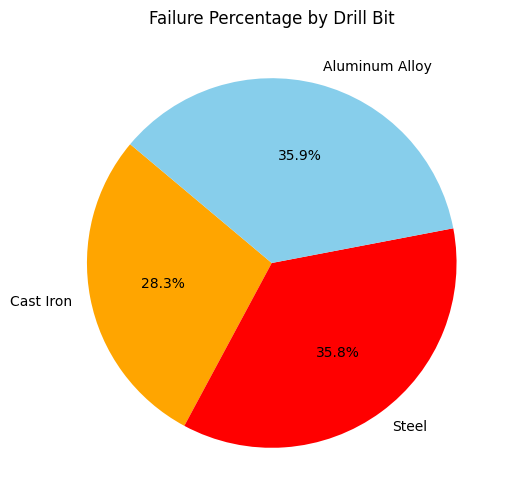

In [24]:

failure_counts = df.groupby('Drill Bit Type')['Main Failure'].sum().reset_index()
failure_counts.columns = ['Drill Bit Types', 'Failure Count']

value_counts = df['Drill Bit Type'].value_counts().reset_index()
value_counts.columns = ['Drill Bit Types', 'Total Count']

failure_counts = failure_counts.merge(value_counts, on='Drill Bit Types')
failure_counts['Failure Percentage'] = (failure_counts['Failure Count'] / failure_counts['Total Count']) * 100

bit_mapping = {'N': 'Steel', 'H': 'Cast Iron', 'W': 'Aluminum Alloy'}
failure_counts['Drill Bit Types'] = failure_counts['Drill Bit Types'].map(bit_mapping)

colors = {'Steel': 'red', 'Cast Iron': 'orange', 'Aluminum Alloy': 'skyblue'}
#colors = {'N': 'red', 'H': 'orange', 'W': 'skyblue'}

plt.figure(figsize=(10, 6))
plt.pie(failure_counts['Failure Percentage'], labels=failure_counts['Drill Bit Types'],
        autopct='%1.1f%%', startangle=140, colors=[colors[label] for label in failure_counts['Drill Bit Types']])
plt.title('Failure Percentage by Drill Bit')
plt.show()

Each drill bit type accounts for roughly equal percent of failures

**Which columns are most highly correlated?**

In [ ]:
# convert Material attribute into numbers, so that  P= 0, K = 1, and N = 2
df['Material'].replace('P', 0, inplace=True)
df['Material'].replace('K', 1, inplace=True)
df['Material'].replace('N', 2, inplace=True)

<ipython-input-33-30e99e082b29>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Material'].replace('P', 0, inplace=True)
<ipython-input-33-30e99e082b29>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [ ]:
# convert Drill Bit Type attribute into numbers, so that W = 0, H = 1, and N = 2
df['Drill Bit Type'].replace('W', 0, inplace=True)
df['Drill Bit Type'].replace('H', 1, inplace=True)
df['Drill Bit Type'].replace('N', 2, inplace=True)

<ipython-input-34-2ac221311891>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Drill Bit Type'].replace('W', 0, inplace=True)
<ipython-input-34-2ac221311891>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

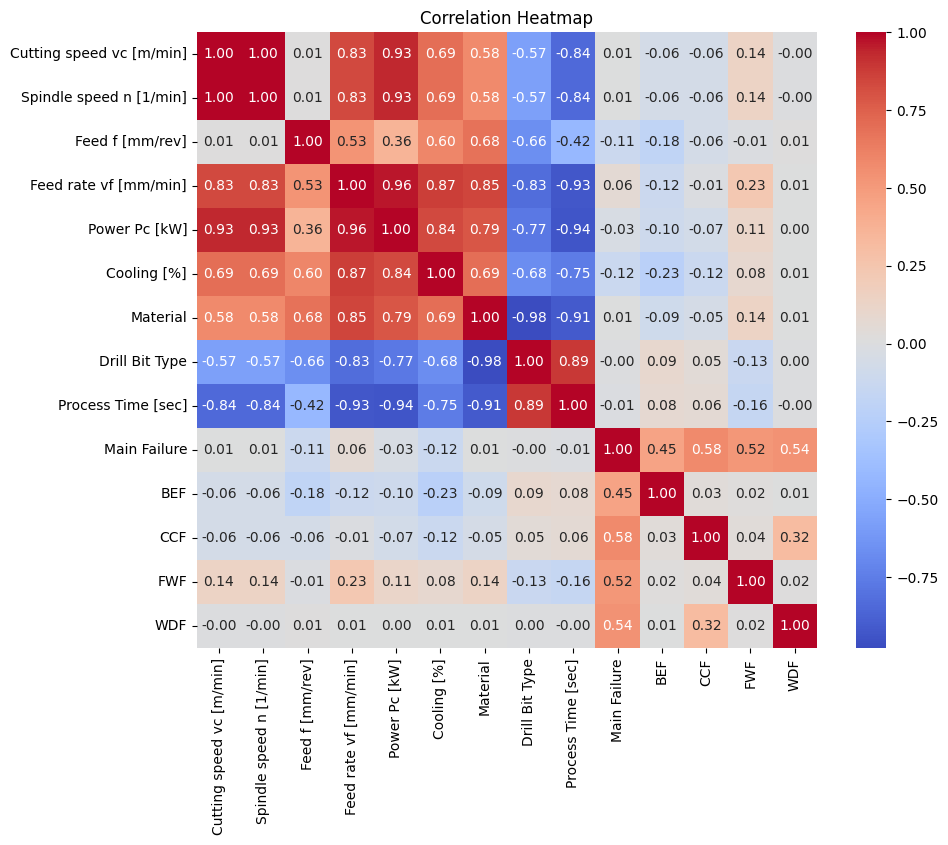

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap');

We can see that cooling level, feed, and feed rate are the most strongly correlated with machine failure.

#Inferential Analysis

Power consumption is the one aspect of the drilling process that cannot be directly controlled. Lets see if there is a significant difference in power consumption between drill bit types and material.

In [ ]:
#convert Material back to letters
df['Material'].replace(0, 'P', inplace=True)
df['Material'].replace(1, 'K', inplace=True)
df['Material'].replace(2, 'N', inplace=True)

In [ ]:
#convert Drill Bit Type back to letters
df['Drill Bit Type'].replace(0, 'W', inplace=True)
df['Drill Bit Type'].replace(1, 'H', inplace=True)
df['Drill Bit Type'].replace(2, 'N', inplace=True)

####ANOVA Tests

In [ ]:
alpha = 0.05

drillbit_df = df[['Material', 'Power Pc [kW]']].copy()

groups = drillbit_df.groupby('Material')['Power Pc [kW]']

P_values = groups.get_group('P')
K_values = groups.get_group('K')
N_values = groups.get_group('N')

f_stat, p_value = f_oneway(P_values, K_values, N_values)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject the Null: There is a significant difference in power consumption when drilling different materials.")
else:
    print("Unable to reject the null: There is no significant difference in power consumption when drilling different materials.")

F-statistic: 173859.5554
P-value: 0.0000
Reject the Null: There is a significant difference in power consumption when drilling different materials.


In [ ]:
alpha = 0.05

drillbit_df = df[['Drill Bit Type', 'Power Pc [kW]']].copy()

groups = drillbit_df.groupby('Drill Bit Type')['Power Pc [kW]']

W_values = groups.get_group('W')
H_values = groups.get_group('H')
N_values = groups.get_group('N')

f_stat, p_value = f_oneway(W_values, H_values, N_values)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject the Null: There is a significant difference in power consumption when using different drill bits.")
else:
    print("Unable to reject the null: There is no significant difference in power consumption when using different drill bits.")

F-statistic: 93286.0396
P-value: 0.0000
Reject the Null: There is a significant difference in power consumption when using different drill bits.


Something is weird with those results. Lets check the distribution of power consumption.

<Axes: xlabel='Power Pc [kW]', ylabel='Count'>

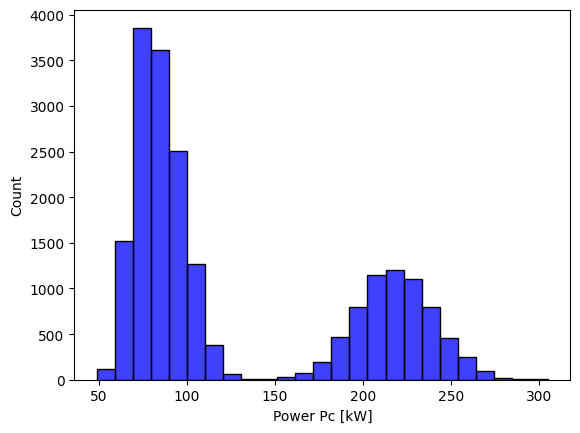

In [ ]:
sns.histplot(df['Power Pc [kW]'], bins=25, kde=False, color='blue')


There is the problem. Its bimodal

IndexError: index 3 is out of bounds for axis 0 with size 3

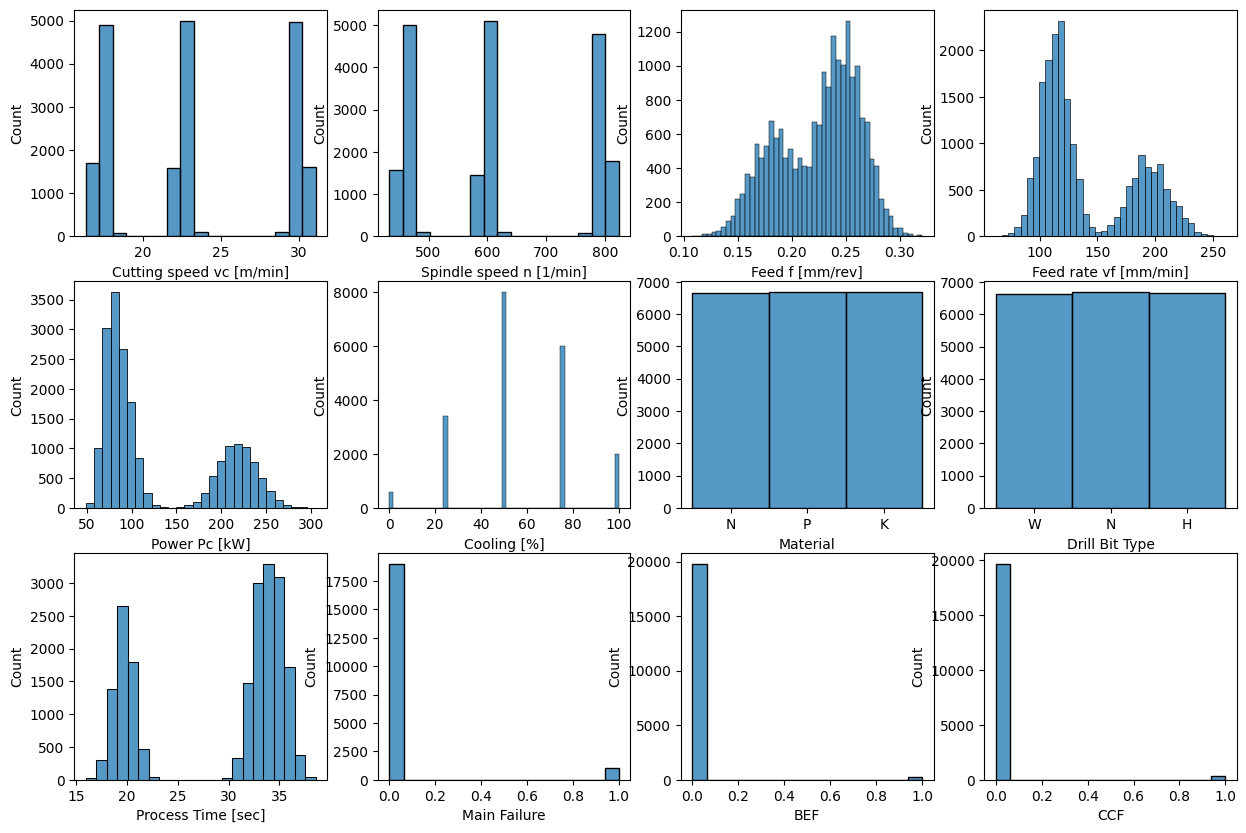

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i//4][i%4])

A lot of features are bimodal even trimodal

Given this discovery, we can use a much simpler method to figure out power consumption across materials.

In [ ]:
material_p = df[df['Material'] == 'P']
material_p['Power Pc [kW]'].mean()

92.34040755169313

In [ ]:
material_n = df[df['Material'] == 'N']
material_n['Power Pc [kW]'].mean()

218.60544347564644

In [ ]:
material_k = df[df['Material'] == 'K']
material_k['Power Pc [kW]'].mean()

76.32788882229546

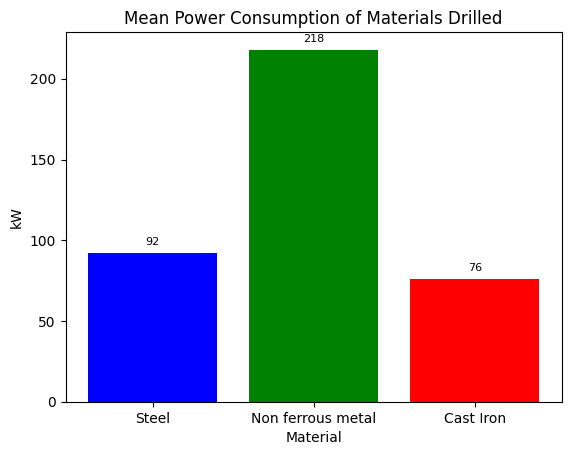

In [29]:
values = [92, 218, 76]
labels = ["Steel", "Non ferrous metal", "Cast Iron"]

colors = ['blue', 'green', 'red']

plt.bar(labels, values, color=colors)

plt.title("Mean Power Consumption of Materials Drilled")
plt.xlabel("Material")
plt.ylabel("kW")
plt.xticks(rotation=0)

for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=8)

plt.show()

This makes sense with the power consumption plot. We can see that drilling into N (non-ferrous metal) consumes more than twice the power than driling into P (steel) or K (cast Iron).



Lets do the same for drill bit type.

In [ ]:
drillbit_n = df[df['Drill Bit Type'] == 'N']
drillbit_n['Power Pc [kW]'].mean()

93.10263008373204

In [ ]:
drillbit_w = df[df['Drill Bit Type'] == 'W']
drillbit_w['Power Pc [kW]'].mean()

216.65137246049662

In [ ]:
drillbit_h = df[df['Drill Bit Type'] == 'H']
drillbit_h['Power Pc [kW]'].mean()

77.62664766761662

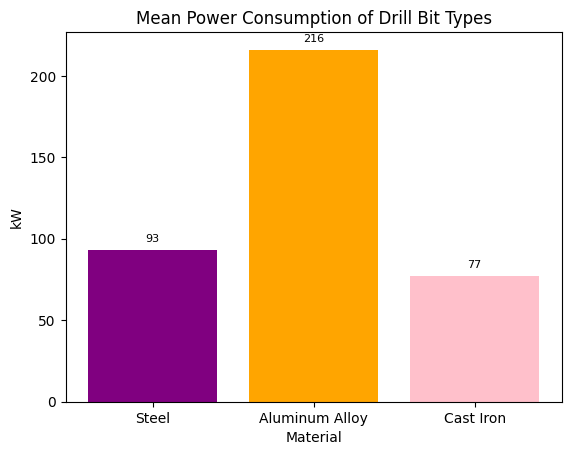

In [4]:
values = [93, 216, 77]
labels = ["Steel", "Aluminum Alloy", "Cast Iron"]

colors = ['purple', 'orange', 'pink']

plt.bar(labels, values, color=colors)

plt.title("Mean Power Consumption of Drill Bit Types")
plt.xlabel("Material")
plt.ylabel("kW")
plt.xticks(rotation=0)

for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=8)

plt.show()

Same story. When using a W (aluminun-silicon alloy) drill bit, the drill consumes more than twice the power than using a N (carbon steel) or H (cast iron) drill bit

##Conclusion

Through this descriptive analysis we found that compression chip failure was the most common type of failure. We then looked at correlations and found that cooling level, feed, and feed rate were the most strongly correlated with machine failure. We then looked at drill bit types and materials and found that they accounted for roughly the same percentage of failures. We dug deeper into drill bit types and materials with inferential analysis. Through our inferential analysis we were able to overwhelmingly reject our nulls. This meant that power consumption across different materials and drill bit types was highly varied.

##Appendix

https://www.steelnumber.com/en/equivalent_steel_iron_eu.php?zname_id=2013

https://www.steelnumber.com/en/steel_composition_eu.php?name_id=152

https://prototool.com/feed-rate-depth-of-cut-an-cutting-speed/
